<a href="https://colab.research.google.com/github/SenolIsci/ML-Model-Starters/blob/main/Univariate_Multivariate_Multistep_CNN_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 we will explore how to develop a suite of different types of CNN models for time series forecasting.

The models are demonstrated on small contrived time series problems intended to give the flavor of the type of time series problem being addressed. The chosen configuration of the models is arbitrary and not optimized for each problem; that was not the goal.

This tutorial is divided into four parts; they are:

* Univariate CNN Models
* Multivariate CNN Models
* Multi-Step CNN Models
* Multivariate Multi-Step CNN Models

#Univariate CNN Models
Although traditionally developed for two-dimensional image data, CNNs can be used to model univariate time series forecasting problems.

Univariate time series are datasets comprised of a single series of observations with a temporal ordering and a model is required to learn from the series of past observations to predict the next value in the sequence.
```
X          y
[10 20 30] 40
[20 30 40] 50
[30 40 50] 60
[40 50 60] 70
[50 60 70] 80
[60 70 80] 90
```

##CNN Model
A one-dimensional CNN is a CNN model that has a convolutional hidden layer that operates over a 1D sequence. This is followed by perhaps a second convolutional layer in some cases, such as very long input sequences, and then a pooling layer whose job it is to distill the output of the convolutional layer to the most salient elements.

The convolutional and pooling layers are followed by a dense fully connected layer that interprets the features extracted by the convolutional part of the model. A flatten layer is used between the convolutional layers and the dense layer to reduce the feature maps to a single one-dimensional vector.

In [12]:
# univariate cnn example
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=1000, verbose=0)
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[101.65491]]


In [13]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 64)             192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 50)                3250      
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 3,493
Trainable params: 3,493
Non-trainable params: 0
____________________________________________________

#Multivariate CNN Models
Multivariate time series data means data where there is more than one observation for each time step.

There are two main models that we may require with multivariate time series data; they are:

* Multiple Input Series.
* Multiple Parallel Series.

##Multivariate Series
A problem may have two or more parallel input time series and an output time series that is dependent on the input time series.

The input time series are parallel because each series has observations at the same time steps.

We can demonstrate this with a simple example of two parallel input time series where the output series is the simple addition of the input series.
```
# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
```
```
[[ 10  15  25]
 [ 20  25  45]
 [ 30  35  65]
 [ 40  45  85]
 [ 50  55 105]
 [ 60  65 125]
 [ 70  75 145]
 [ 80  85 165]
 [ 90  95 185]]
 ```

If we chose three input time steps, then the first sample would look as follows:

Input:
```
10, 15
20, 25
30, 35
Output:

65
```

In [15]:
# multivariate cnn example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=1000, verbose=0)
# demonstrate prediction
x_input = array([[80, 85], [90, 95], [100, 105]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[207.28555]]


In [16]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 2, 64)             320       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 50)                3250      
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 3,621
Trainable params: 3,621
Non-trainable params: 0
____________________________________________________

##Multi Input Series Multi Headed CNN
There is another, more elaborate way to model the problem.

Each input series can be handled by a separate CNN and the output of each of these submodels can be combined before a prediction is made for the output sequence.

We can refer to this as a multi-headed CNN model. It may offer more flexibility or better performance depending on the specifics of the problem that is being modeled. For example, it allows you to configure each sub-model differently for each input series, such as the number of filter maps and the kernel size.

This type of model can be defined in Keras using the Keras functional API.

In [20]:
# multivariate multi-headed 1d cnn example
from numpy import array
from numpy import hstack
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import concatenate
from keras.utils import plot_model

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)
# one time series per head
n_features = 1
# separate input data
X1 = X[:, :, 0].reshape(X.shape[0], X.shape[1], n_features)
X2 = X[:, :, 1].reshape(X.shape[0], X.shape[1], n_features)
# first input model
visible1 = Input(shape=(n_steps, n_features))
cnn1 = Conv1D(filters=64, kernel_size=2, activation='relu')(visible1)
cnn1 = MaxPooling1D(pool_size=2)(cnn1)
cnn1 = Flatten()(cnn1)
# second input model
visible2 = Input(shape=(n_steps, n_features))
cnn2 = Conv1D(filters=64, kernel_size=2, activation='relu')(visible2)
cnn2 = MaxPooling1D(pool_size=2)(cnn2)
cnn2 = Flatten()(cnn2)
# merge input models
merge = concatenate([cnn1, cnn2])
dense = Dense(50, activation='relu')(merge)
output = Dense(1)(dense)
model = Model(inputs=[visible1, visible2], outputs=output)
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit([X1, X2], y, epochs=1000, verbose=0)
# demonstrate prediction
x_input = array([[80, 85], [90, 95], [100, 105]])
x1 = x_input[:, 0].reshape((1, n_steps, n_features))
x2 = x_input[:, 1].reshape((1, n_steps, n_features))
yhat = model.predict([x1, x2], verbose=0)
print(yhat)

[[206.97395]]


In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 1)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 3, 1)]       0           []                               
                                                                                                  
 conv1d_2 (Conv1D)              (None, 2, 64)        192         ['input_1[0][0]']                
                                                                                                  
 conv1d_3 (Conv1D)              (None, 2, 64)        192         ['input_2[0][0]']                
                                                                                              

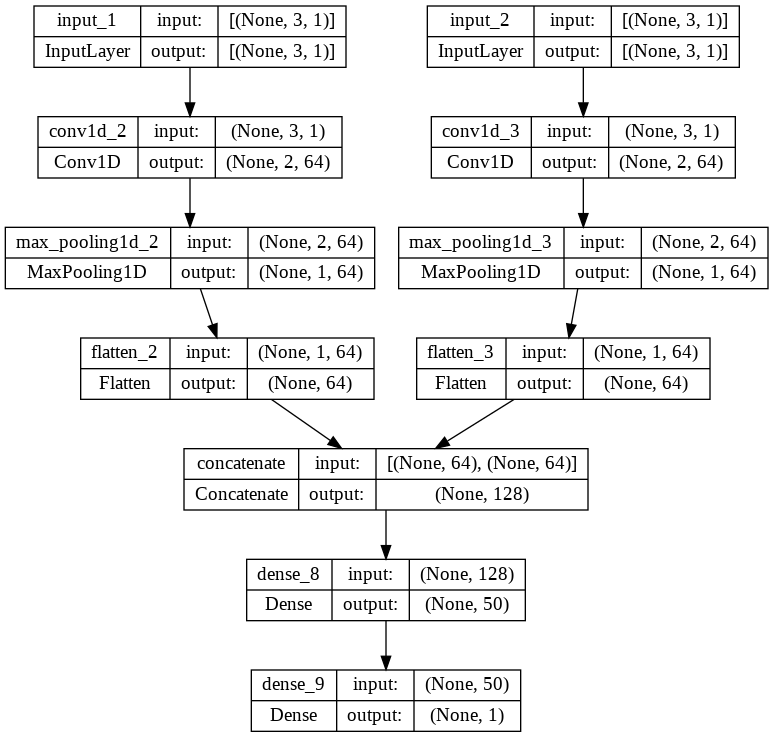

In [22]:
plot_model(model, show_shapes=True)

##Multiple Parallel Series
An alternate time series problem is the case where there are multiple parallel time series and a value must be predicted for each.

For example, given the data from the previous section:
```
[[ 10  15  25]
 [ 20  25  45]
 [ 30  35  65]
 [ 40  45  85]
 [ 50  55 105]
 [ 60  65 125]
 [ 70  75 145]
 [ 80  85 165]
 [ 90  95 185]]
We may want to predict the value for each of the three time series for the next time step.

This might be referred to as multivariate forecasting.

Again, the data must be split into input/output samples in order to train a model.

The first sample of this dataset would be:

Input:

10, 15, 25
20, 25, 45
30, 35, 65
Output:

40, 45, 85
```

In [23]:
# multivariate output 1d cnn example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)
# the dataset knows the number of features, e.g. 3
n_features = X.shape[2]
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=3000, verbose=0)
# demonstrate prediction
x_input = array([[70,75,145], [80,85,165], [90,95,185]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[100.11568 105.48129 205.7832 ]]


In [24]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 2, 64)             448       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 50)                3250      
                                                                 
 dense_11 (Dense)            (None, 3)                 153       
                                                                 
Total params: 3,851
Trainable params: 3,851
Non-trainable params: 0
____________________________________________________

##Multi-output CNN

Each output series can be handled by a separate output CNN model.

We can refer to this as a multi-output CNN model. It may offer more flexibility or better performance depending on the specifics of the problem that is being modeled.

In [25]:
# multivariate output 1d cnn example
from numpy import array
from numpy import hstack
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# separate output
y1 = y[:, 0].reshape((y.shape[0], 1))
y2 = y[:, 1].reshape((y.shape[0], 1))
y3 = y[:, 2].reshape((y.shape[0], 1))
# define model
visible = Input(shape=(n_steps, n_features))
cnn = Conv1D(filters=64, kernel_size=2, activation='relu')(visible)
cnn = MaxPooling1D(pool_size=2)(cnn)
cnn = Flatten()(cnn)
cnn = Dense(50, activation='relu')(cnn)
# define output 1
output1 = Dense(1)(cnn)
# define output 2
output2 = Dense(1)(cnn)
# define output 3
output3 = Dense(1)(cnn)
# tie together
model = Model(inputs=visible, outputs=[output1, output2, output3])
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, [y1,y2,y3], epochs=2000, verbose=0)
# demonstrate prediction
x_input = array([[70,75,145], [80,85,165], [90,95,185]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[array([[99.99992]], dtype=float32), array([[104.99984]], dtype=float32), array([[205.00002]], dtype=float32)]


In [26]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 3, 3)]       0           []                               
                                                                                                  
 conv1d_5 (Conv1D)              (None, 2, 64)        448         ['input_3[0][0]']                
                                                                                                  
 max_pooling1d_5 (MaxPooling1D)  (None, 1, 64)       0           ['conv1d_5[0][0]']               
                                                                                                  
 flatten_5 (Flatten)            (None, 64)           0           ['max_pooling1d_5[0][0]']        
                                                                                            

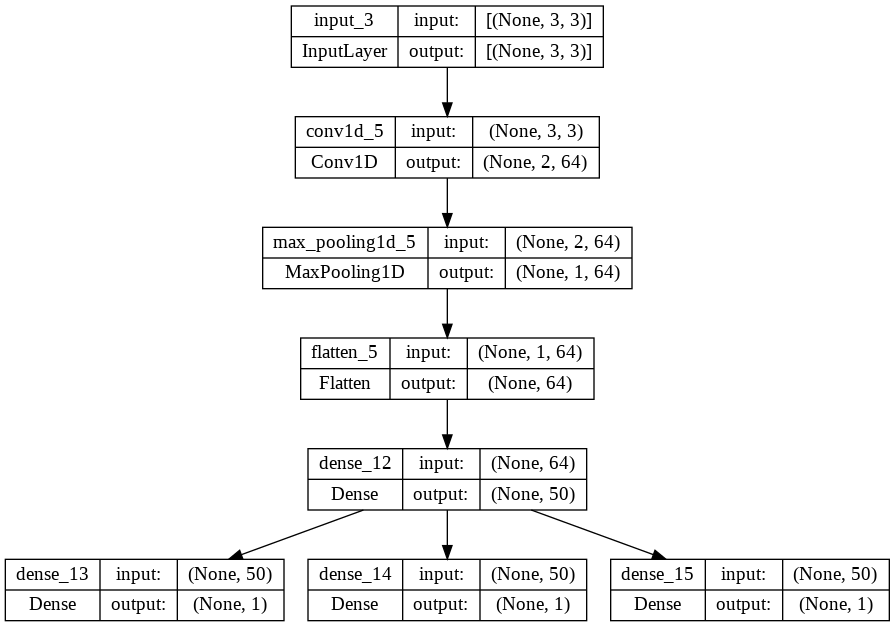

In [27]:
plot_model(model, show_shapes=True)

#Multi-Step CNN Models
In practice, there is little difference to the 1D CNN model in predicting a vector output that represents different output variables (as in the previous example), or a vector output that represents multiple time steps of one variable.

Nevertheless, there are subtle and important differences in the way the training data is prepared. In this section, we will demonstrate the case of developing a multi-step forecast model using a vector model.

For example, given the univariate time series:
```
[10, 20, 30, 40, 50, 60, 70, 80, 90]
We could use the last three time steps as input and forecast the next two time steps.

The first sample would look as follows:

Input:

[10, 20, 30]
Output:

[40, 50]
```



## Univariate Multi-step Vector Output Model
The 1D CNN can output a vector directly that can be interpreted as a multi-step forecast.

This approach was seen in the previous section were one time step of each output time series was forecasted as a vector.

As with the 1D CNN models for univariate data in a prior section, the prepared samples must first be reshaped. The CNN expects data to have a three-dimensional structure of [samples, timesteps, features], and in this case, we only have one feature so the reshape is straightforward.##

In [29]:
# univariate multi-step vector-output 1d cnn example
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=2000, verbose=0)
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[103.10492 115.58018]]


In [30]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 2, 64)             192       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 50)                3250      
                                                                 
 dense_17 (Dense)            (None, 2)                 102       
                                                                 
Total params: 3,544
Trainable params: 3,544
Non-trainable params: 0
____________________________________________________

#Multivariate Multi-Step CNN Models
In the previous sections, we have looked at univariate, multivariate, and multi-step time series forecasting.

It is possible to mix and match the different types of 1D CNN models presented so far for the different problems. This too applies to time series forecasting problems that involve multivariate and multi-step forecasting, but it may be a little more challenging.

In this section, we will explore short examples of data preparation and modeling for multivariate multi-step time series forecasting as a template to ease this challenge, specifically:

* Multiple Input Multi-Step Output.
* Multiple Parallel Input and Multi-Step Output.

Perhaps the biggest stumbling block is in the preparation of data, so this is where we will focus our attention.

```
For example, consider our multivariate time series from a prior section:

[[ 10  15  25]
 [ 20  25  45]
 [ 30  35  65]
 [ 40  45  85]
 [ 50  55 105]
 [ 60  65 125]
 [ 70  75 145]
 [ 80  85 165]
 [ 90  95 185]]
We may use three prior time steps of each of the two input time series to predict two time steps of the output time series.

Input:

10, 15
20, 25
30, 35
Output:

65
85
```

In [32]:
# multivariate multi-step 1d cnn example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# convert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=2000, verbose=0)
# demonstrate prediction
x_input = array([[70, 75], [80, 85], [90, 95]])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[185.65723 207.54451]]


In [33]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 2, 64)             320       
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 50)                3250      
                                                                 
 dense_19 (Dense)            (None, 2)                 102       
                                                                 
Total params: 3,672
Trainable params: 3,672
Non-trainable params: 0
____________________________________________________

##Multiple Parallel Input and Multi-Step Output
A problem with parallel time series may require the prediction of multiple time steps of each time series.

For example, consider our multivariate time series from a prior section:
```
[[ 10  15  25]
 [ 20  25  45]
 [ 30  35  65]
 [ 40  45  85]
 [ 50  55 105]
 [ 60  65 125]
 [ 70  75 145]
 [ 80  85 165]
 [ 90  95 185]]
We may use the last three time steps from each of the three time series as input to the model, and predict the next time steps of each of the three time series as output.

The first sample in the training dataset would be the following.

Input:

10, 15, 25
20, 25, 45
30, 35, 65
Output:

40, 45, 85
50, 55, 105
```

In [39]:
# multivariate output multi-step 1d cnn example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# convert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
# flatten output
n_output = y.shape[1] * y.shape[2]
y = y.reshape((y.shape[0], n_output))
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(n_output))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=7000, verbose=0)
# demonstrate prediction
x_input = array([[60, 65, 125], [70, 75, 145], [80, 85, 165]])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat.reshape(-1,n_features))

[[ 91.283554  96.984856 189.47188 ]
 [103.333176 108.46396  211.58649 ]]


In [40]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 2, 64)             448       
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 1, 64)            0         
 g1D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 64)                0         
                                                                 
 dense_24 (Dense)            (None, 50)                3250      
                                                                 
 dense_25 (Dense)            (None, 6)                 306       
                                                                 
Total params: 4,004
Trainable params: 4,004
Non-trainable params: 0
___________________________________________________